In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45

In [8]:
def get_net(net_type, net_order, rng=None):
    if net_type == 'scale_free':
        return nx.barabasi_albert_graph(n=net_order, m=2, seed=rng, initial_graph=nx.complete_graph(3))

    elif net_type == 'complete_mixing':
        return nx.complete_graph(n=net_order)

    elif net_type == 'lattice':
        return nx.grid_2d_graph(int(np.sqrt(net_order)), int(np.sqrt(net_order)), periodic=False)

    else:
        return None

#Computation of the degree distribution (degree_distrib[:,0]:number of counts, degree_distrib[0,1]:degree),mean degree 
#and the dimension (maximum degree-minimum degree)
def degree_distribution(G):
    adjG = nx.to_numpy_array(G)
    degrees = np.zeros(net_order)
    meandegree = 0

    for i in range(0,len(adjG[0])):
        degrees[i] = np.sum(adjG[:,i])

    degmax = int(np.max(degrees))
    degmin = int(np.min(degrees))
    dim = degmax-degmin+1
    degree_distrib = np.zeros((dim,2))

    for j in range(0,dim):
        degree_distrib[j,1] =  j+degmin

    for i in range(0,net_order):
        for j in range(0,dim):
            if(degrees[i]==(j+degmin)):
                degree_distrib[j,0] =  degree_distrib[j,0]+1
    for i in range(0,dim):
        meandegree = meandegree + degree_distrib[i,0]*degree_distrib[i,1]
    meandegree = meandegree/dim
    return degree_distrib,meandegree,dim

#Computation of the parenthesis of equation (5) in the Mean Field article
def complete_integration(x,distopinionsk,distopinionsl):
    #First term/integral of the parenthesis
    xaxis = np.linspace(start=0,stop=1,num=Ngaps+1)
    #Computation of the range (max and min y) in which the y is going to be: yinf and ysup for the first prob Pk and 
    #yinf2 and ysup2 for the second prob Pl
    yinf = x-threshold*convergence
    ysup = x+threshold*convergence
    ysup2 = yinf + 1/convergence*(x-yinf)
    yinf2 = ysup + 1/convergence*(x-ysup)
    if(yinf<0):
        yinf = 0
    if(ysup>1):
        ysup = 1
    if(yinf2<0):
        yinf2 = 0
    if(ysup2>1):
        ysup2 = 1
    #Computation of the index of each of the extremes of the range
    for i in range(0,Ngaps):
        if (xaxis[i]<=yinf<xaxis[i+1]):
            gapinf = i
        if (xaxis[i]<ysup<=xaxis[i+1]):
            gapsup = i+1
        if (xaxis[i]<=yinf2<xaxis[i+1]):
            gapinf2 = i
        if (xaxis[i]<ysup2<=xaxis[i+1]):
            gapsup2 = i+1
    ind=gapsup2-gapinf2-1
    jump = int(ind/(gapsup-gapinf-1))
    #The jump from one y value to the next one is given by the difference between indexes but, for the second
    #probability it will depend on the x value and its difference from y
    positiveint = 0
    for j in range(gapinf,gapsup):
        positiveint = positiveint + distopinionsk[j]*distopinionsl[ind+1]
        ind = ind - jump
    #Computation of the second term/integral of the parenthesis
    #Computation of the extremes of y
    yinfneg = np.round(x-threshold,4)
    ysupneg = np.round(x+threshold,4)
    if(yinfneg<0):
        yinfneg = 0
    if(ysupneg>1):
        ysupneg = 1
    #Computation of its respective indexes
    for i in range(0,Ngaps):
        if (xaxis[i]<=yinfneg<xaxis[i+1]):
            gapinfneg = i
        if (xaxis[i]<ysupneg<=xaxis[i+1]):
            gapsupneg = i+1
        if (xaxis[i]<=x<=xaxis[i+1]):
            xind = i
    negativeint = 0
    for j in range(gapinfneg,gapsupneg):
        negativeint = negativeint + distopinionsk[xind]*distopinionsl[j]
    #We return the number inside the parenthesis
    return (1/threshold*positiveint-negativeint)

#Computation of the right hand part of the equation (5) with the sum over all the possible degrees
def functionf(x,k,opiniondistrib):
    totalsum = 0
    for i in range(0,dim):
        ql = degree_distrib[i,0]/net_order
        totalsum = totalsum + k*degree_distrib[i,1]*ql/(meandegree**2)*complete_integration(x,opiniondistrib[k,:],opiniondistrib[i,:])
        #print(totalsum,k*degree_distrib[i,1]*ql/(meandegree**2),complete_integration(x,opiniondistrib[k,:],opiniondistrib[i,:]))
    return totalsum

#Resolution of the system of differential equations. First: degree_basedMFini which uses for the first 4 time steps 
#the Euler method and degree_basedMF which already takes the previous 4 and continues with the Adam Bashford method
'''
def degree_basedMFini(G,dt,opiniondistrib):
    totaldistrib = np.zeros(Ngaps)
    print(dim)
    #We compute for the first 4 times with the Euler method for all x values (j index) and possible degrees (i index)
    for t in range(1,4):
        for j in range(0,Ngaps):
            x = j/Ngaps
            for i in range(0,dim):
                opiniondistrib[i,j,t] = opiniondistrib[i,j,t-1] + dt*functionf(x,i,opiniondistrib[:,:,t-1])
    #For the next temporal steps we use the Adam Bashford method
    for t in range(4,Nsteps):
        for j in range(0,Ngaps):
            x = j/Ngaps
            for i in range(0,dim):
                opiniondistrib[i,j,t] = opiniondistrib[i,j,t-1]+dt*(55/24*functionf(x,i,opiniondistrib[:,:,t-1])
                                                                            -59/24*functionf(x,i,opiniondistrib[:,:,t-2])
                                                                            +37/24*functionf(x,i,opiniondistrib[:,:,t-3])
                                                                            -9/24*functionf(x,i,opiniondistrib[:,:,t-4]))
                #print(opiniondistrib)
                totaldistrib[j] = totaldistrib[j] + degree_distrib[i,0]/net_order*opiniondistrib[i,j,t]
        #We substitute the previous times with the computed ones
        opiniondistrib[:,:,t-4] = np.copy(opiniondistrib[:,:,t-3])
        opiniondistrib[:,:,t-3] = np.copy(opiniondistrib[:,:,t-2])
        opiniondistrib[:,:,t-2] = np.copy(opiniondistrib[:,:,t-1])
        opiniondistrib[:,:,t-1] = np.copy(opiniondistrib[:,:,t])
            
    return opiniondistrib,totaldistrib  
'''

def degree_basedMFini(G,dt,opiniondistrib):
    totaldistrib = np.zeros(Ngaps)
    print(dim)
    #We compute for the first 4 times with the Euler method for all x values (j index) and possible degrees (i index)
    for j in range(0,Ngaps):
        x = j/Ngaps
        for i in range(0,dim):
            opiniondistrib[i,j,1] = RK45(lambda xx: functionf(xx,i,opiniondistrib[:,:,0]),0,opiniondistrib[:,:,0],dt,rtol=1,atol=1).step()
            opiniondistrib[i,j,2] = RK45(lambda xx: functionf(xx,i,opiniondistrib[:,:,1]),dt,opiniondistrib[:,:,0],2*dt,rtol=1,atol=1).step()
            opiniondistrib[i,j,3] = RK45(lambda xx: functionf(xx,i,opiniondistrib[:,:,2]),2*dt,opiniondistrib[:,:,0],3*dt,rtol=1,atol=1).step()
    #For the next temporal steps we use the Adam Bashford method
    for t in range(4,Nsteps):
        for j in range(0,Ngaps):
            x = j/Ngaps
            for i in range(0,dim):
                opiniondistrib[i,j,t] = opiniondistrib[i,j,t-1]+dt*(55/24*functionf(x,i,opiniondistrib[:,:,t-1])
                                                                            -59/24*functionf(x,i,opiniondistrib[:,:,t-2])
                                                                            +37/24*functionf(x,i,opiniondistrib[:,:,t-3])
                                                                            -9/24*functionf(x,i,opiniondistrib[:,:,t-4]))
                #print(opiniondistrib)
                totaldistrib[j] = totaldistrib[j] + degree_distrib[i,0]/net_order*opiniondistrib[i,j,t]
        #We substitute the previous times with the computed ones
        opiniondistrib[:,:,t-4] = np.copy(opiniondistrib[:,:,t-3])
        opiniondistrib[:,:,t-3] = np.copy(opiniondistrib[:,:,t-2])
        opiniondistrib[:,:,t-2] = np.copy(opiniondistrib[:,:,t-1])
        opiniondistrib[:,:,t-1] = np.copy(opiniondistrib[:,:,t])
            
    return opiniondistrib,totaldistrib 

def degree_basedMF(G,dt,opiniondistrib):
    totaldistrib = np.zeros(Ngaps)
    #print('hasta aqui')
    for t in range(0,Nsteps):
        for j in range(0,Ngaps):
            x = j/Ngaps
            for i in range(0,dim):
                opiniondistrib[i,j,t] = opiniondistrib[i,j,t-1]+dt*(55/24*functionf(x,i,opiniondistrib[:,:,t-1])
                                                                            -59/24*functionf(x,i,opiniondistrib[:,:,t-2])
                                                                            +37/24*functionf(x,i,opiniondistrib[:,:,t-3])
                                                                            -9/24*functionf(x,i,opiniondistrib[:,:,t-4]))
                totaldistrib[j] = totaldistrib[j] + degree_distrib[i,0]/net_order*opiniondistrib[i,j,t]
        #print('hasta aqui{}'.format(t))
        opiniondistrib[:,:,t-4] = np.copy(opiniondistrib[:,:,t-3])
        opiniondistrib[:,:,t-3] = np.copy(opiniondistrib[:,:,t-2])
        opiniondistrib[:,:,t-2] = np.copy(opiniondistrib[:,:,t-1])
        opiniondistrib[:,:,t-1] = np.copy(opiniondistrib[:,:,t])
            
    return opiniondistrib,totaldistrib  

hasta aqui
13
hasta aqui
hasta aqui4
hasta aqui5
hasta aqui6
hasta aqui7
hasta aqui8
hasta aqui9
[0.15009705 0.15015534 0.15021351 0.15027211 0.15032947 0.15038722
 0.15044557 0.1505031  0.15055974 0.15061695 0.15067139 0.15052299
 0.15058081 0.15042888 0.15048402 0.15043623 0.15028761 0.15034567
 0.15019377 0.15029679 0.1501933  0.15014662 0.15019324 0.15034673
 0.15023841 0.15028714 0.15038105 0.15042801 0.1505814  0.15052137
 0.15052232 0.15061657 0.15051246 0.15060782 0.1504431  0.15034061
 0.15032982 0.15022522 0.15032003 0.15015448]
[[[0.025      0.025      0.025      ... 0.025      0.025      0.025     ]
  [0.025      0.025      0.025      ... 0.025      0.025      0.025     ]
  [0.025      0.025      0.025      ... 0.025      0.025      0.025     ]
  ...
  [0.025      0.025      0.025      ... 0.025      0.025      0.025     ]
  [0.025      0.025      0.025      ... 0.025      0.025      0.025     ]
  [0.025      0.025      0.025      ... 0.025      0.025      0.025     ]]

 [[

KeyboardInterrupt: 

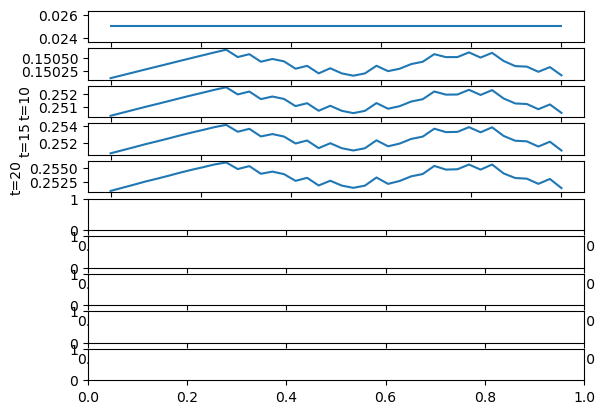

In [10]:
net_order = 20
symmetric_updating = False
threshold = 0.45
convergence = 0.5
Ngaps = 40
Nsteps = 10
dt=0.01
totaldist = np.zeros(Ngaps)

fig,ax = plt.subplots(Nsteps,1)

G = get_net('scale_free',net_order=net_order,rng=None)
degree_distrib,meandegree,dim = degree_distribution(G)
opiniondistrib = np.zeros((dim,Ngaps,Nsteps))

for j in range(0,Ngaps):
    for i in range(0,dim):
        opiniondistrib[i][j][0] = 1/Ngaps
    totaldist[j] = 1/Ngaps

ax[0].plot(np.linspace(start=0,stop=1,num=Ngaps),totaldist)
opiniondistrib,totaldist = degree_basedMFini(G,dt,opiniondistrib)
print(totaldist)
ax[1].plot(np.linspace(start=0,stop=1,num=Ngaps),totaldist)

for i in range(2,Nsteps):
    opiniondistrib,totaldist = degree_basedMF(G,dt,opiniondistrib)
    print(opiniondistrib)
    ax[i].plot(np.linspace(start=0,stop=1,num=Ngaps),totaldist)
    ax[i].set_ylabel("t={}".format(i*5))
    #ax[i].set_ylim(0,7)

plt.subplots_adjust(hspace=0)

In [9]:
net_order = 900
symmetric_updating = False
threshold = 0.3
convergence = 0.2
Ngaps = 40
Nsteps = 5
dt=0.0001
totaldist = np.zeros((Ngaps,5))
G = get_net('scale_free',net_order=net_order,rng=None)
degree_distrib,meandegree,dim = degree_distribution(G)
opiniondistrib = np.zeros((Ngaps,2))
print(np.shape(opiniondistrib))

for i in range(0,Ngaps):
        opiniondistrib[i,0] = i/(Ngaps)
        opiniondistrib[i,1] = 1/(Ngaps+5*i)

num = complete_integration(0.5,opiniondistrib[:,0],opiniondistrib[:,1])
print(num)

(40, 2)
0.010605570296499764


In [12]:
net_order = 900
symmetric_updating = False
threshold = 0.5
convergence = 0.3
Ngaps = 40
Nsteps = 5
dt=0.0001
totaldist = np.zeros((Ngaps,5))

G = get_net('scale_free',net_order=net_order,rng=None)
degree_distrib,meandegree,dim = degree_distribution(G)
opiniondistrib = np.zeros((dim,Ngaps))

for j in range(0,Ngaps):
    for i in range(0,dim):
        opiniondistrib[i][j] = i*j/Ngaps
        
#print(opiniondistrib[5,:],opiniondistrib[2,:])
functionf(x=0.3,k=5,opiniondistrib=opiniondistrib)

0.0 0.0012688401401086146 0.0
-0.004769417071254911 0.0007000979187163171 -6.8125
-0.011852144218986754 0.0005198331851546307 -13.625
-0.01999156856214633 0.0003982592950781445 -20.4375
-0.027074295709878175 0.00025991659257731535 -27.25
-0.033071766278522076 0.00017607253045560074 -34.0625
-0.039469068218408905 0.00015650891596053398 -40.875
-0.04786552701451037 0.0001760725304556007 -47.687500000000014
-0.050911861271599336 5.5896041414476417e-05 -54.5
-0.05750907889710762 0.0001075998797228671 -61.3125
-0.06664808166837452 0.0001341504993947434 -68.125
-0.06937074291064778 3.633242691940967e-05 -74.93749999999999
-0.0741687193655629 5.869084348520024e-05 -81.75
-0.08716323893095801 0.0001467271087130006 -88.56250000000003
-0.08929567291092029 2.2358416565790568e-05 -95.37500000000003
-0.10386095857762691 0.00014253490560691486 -102.1875
-0.10660265940900698 2.515321863651439e-05 -109.0
-0.10660265940900698 0.0 -115.8125
-0.11002978544823207 2.7948020707238208e-05 -122.625
-0.1100297

-0.2673539102377703